In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
# Load datasets
day_df = pd.read_csv(r'D:\learning\data science\DICODING EDITION\submission\data\day.csv')
hour_df = pd.read_csv(r'D:\learning\data science\DICODING EDITION\submission\data\hour.csv')

# Preview datasets
print("Preview of day dataset:")
print(day_df.head(), "\n")

print("Preview of hour dataset:")
print(hour_df.head())

Preview of day dataset:
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600   



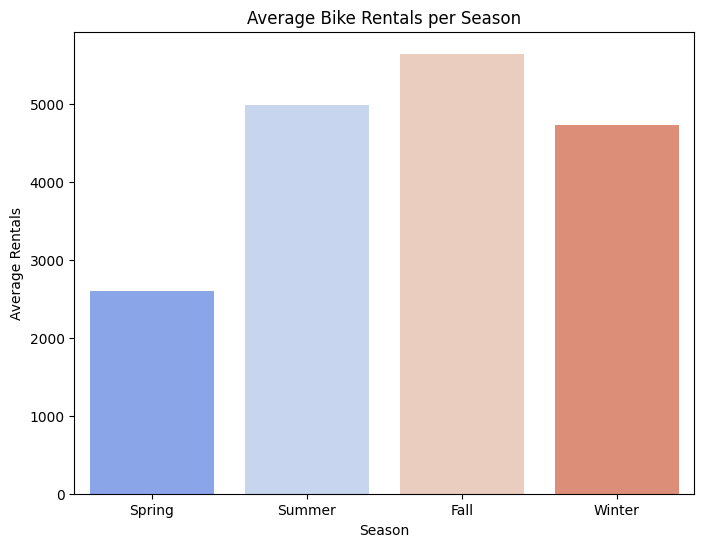

In [57]:
# Total rental bikes per season
seasonal_data = day_df.groupby('season')['cnt'].mean()

# Mapping season index to readable labels
season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
seasonal_data.index = seasonal_data.index.map(season_map)

# Visualisasi
plt.figure(figsize=(8, 6))
sns.barplot(x=seasonal_data.index, y=seasonal_data.values, palette='coolwarm', hue=seasonal_data.index)
plt.legend([],[], frameon=False)  # Menghapus legend jika tidak diperlukan
plt.title('Average Bike Rentals per Season')
plt.xlabel('Season')
plt.ylabel('Average Rentals')
plt.show()

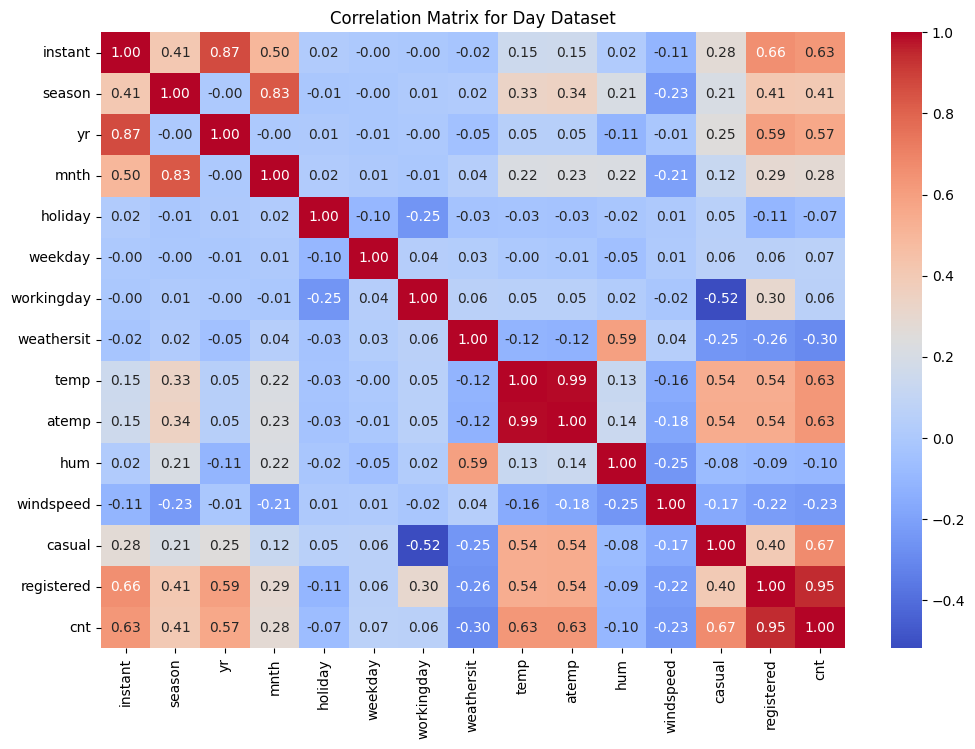

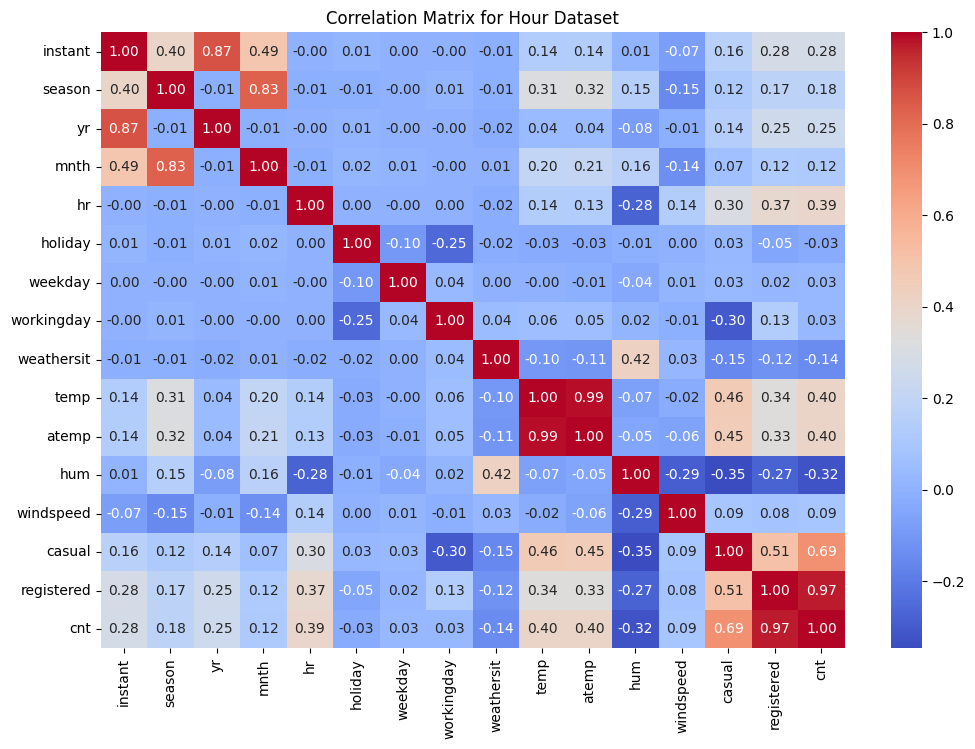

In [ ]:
# ==========================================
# Preprocess to Drop Non-Numeric Columns
# ==========================================
day_numeric = day_df.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
hour_numeric = hour_df.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns

# ==========================================
# Correlation Matrix for Day Dataset
# ==========================================
plt.figure(figsize=(12, 8))
day_corr = day_numeric.corr()  # Compute correlation only on numeric columns
sns.heatmap(day_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix for Day Dataset')
plt.show()

# ==========================================
# Correlation Matrix for Hour Dataset
# ==========================================
plt.figure(figsize=(12, 8))
hour_corr = hour_numeric.corr()  # Compute correlation only on numeric columns
sns.heatmap(hour_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix for Hour Dataset')
plt.show()

In [59]:
# ==========================================
# 1. Tren Musiman: Peminjaman Berdasarkan Musim
# ==========================================
season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
day_df['season_label'] = day_df['season'].map(season_map)

seasonal_data = day_df.groupby('season_label')['cnt'].mean().reset_index()
seasonal_data.to_csv('seasonal_trend.csv', index=False)

In [60]:
# ==========================================
# 2. Pengaruh Cuaca terhadap Peminjaman
# ==========================================
weather_map = {
    1: 'Clear',
    2: 'Mist + Cloudy',
    3: 'Light Snow/Rain',
    4: 'Heavy Rain/Snow'
}
day_df['weather_label'] = day_df['weathersit'].map(weather_map)

weather_data = day_df.groupby('weather_label')['cnt'].mean().reset_index()
weather_data.to_csv('weather_influence.csv', index=False)

In [61]:
# ==========================================
# 3. Kebiasaan Harian: Hari Kerja vs Akhir Pekan
# ==========================================
weekday_data = day_df.groupby(['workingday'])['cnt'].mean().reset_index()
weekday_data['workingday_label'] = weekday_data['workingday'].map({0: 'Non-Working Day', 1: 'Working Day'})
weekday_data.to_csv('weekday_trend.csv', index=False)

In [62]:
# ==========================================
# 4. Perilaku Berdasarkan Jam (Dataset Hour)
# ==========================================
hourly_data = hour_df.groupby('hr')['cnt'].mean().reset_index()
hourly_data.to_csv('hourly_trend.csv', index=False)

In [63]:

# ==========================================
# 5. Prediksi Total Peminjaman (cnt)
# ==========================================
# Selecting features and target
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = day_df[features]
y = day_df['cnt']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Adding predictions to dataset
day_df['predicted_cnt'] = model.predict(X)
day_df[['dteday', 'cnt', 'predicted_cnt']].to_csv('predictions_day.csv', index=False)

In [64]:
# ==========================================
# 6. Analisis RFM
# ==========================================
latest_date = pd.to_datetime(day_df['dteday']).max()
day_df['Recency'] = (latest_date - pd.to_datetime(day_df['dteday'])).dt.days
day_df['Frequency'] = day_df['registered']
day_df['Monetary'] = day_df['cnt']

day_df['R_Score'] = pd.qcut(day_df['Recency'], 4, labels=[4, 3, 2, 1])
day_df['F_Score'] = pd.qcut(day_df['Frequency'], 4, labels=[1, 2, 3, 4])
day_df['M_Score'] = pd.qcut(day_df['Monetary'], 4, labels=[1, 2, 3, 4])
day_df['RFM_Segment'] = day_df['R_Score'].astype(str) + day_df['F_Score'].astype(str) + day_df['M_Score'].astype(str)

rfm_data = day_df[['dteday', 'R_Score', 'F_Score', 'M_Score', 'RFM_Segment']]
rfm_data.to_csv('rfm_analysis.csv', index=False)